# VNC of tfes.org

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import sys
import os
import json
import itertools

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from nltk import ngrams as make_ngrams
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from helpers import load_posts, load_toks, load_pos, get_top_n_toks
from language_change_methods.vnc import VNC, plot_vnc
from language_change_methods.utility_functions import get_data_windows, get_time_windows, basic_preprocessing
from language_change_methods.features import get_tok_counts, function_words, combine_counts, make_feature_matrix

from language_change_methods.features import get_ngram_lr_and_ll
from language_change_methods.word_clouds import make_wordcloud

# This method calculates cosine distance between two vectors.
from scipy.spatial.distance import cosine as cosine_dist
# This method simply inverts it to get similarity.
cosine_sim = lambda x,y: 1 - cosine_dist(x,y)

from sklearn.metrics import jaccard_score

from settings import TFES_FP as DB_FP, TFES_TOK_FP
OUT_DIR = "./Graphs"

## Load Data

In [2]:
%%time
all_posts = load_posts(DB_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = all_posts.query("board_id in @flat_earth_boards")
ot_posts = all_posts.query("board_id in @other_boards")

toks = {int(x[0]): x[1] for x in load_toks(TFES_TOK_FP)}
toks = pd.Series(toks)
toks = toks[toks.index.isin(fe_posts.index)]

pos = {int(x[0]): x[1] for x in load_pos(TFES_TOK_FP)}
pos = pd.Series(pos)
pos = pos[pos.index.isin(fe_posts.index)]

fe_posts = fe_posts.loc[toks.index]

Wall time: 31 s


## Get the Feature Counts Per Window

In [3]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

In [4]:
%%time
window_toks = {curr_date: merge_lists(toks.loc[curr_window.index]) 
               for curr_date, curr_window in get_data_windows(fe_posts, 5000, 5000)}

window_toks = pd.Series(window_toks)

Wall time: 392 ms


### BoW

In [5]:
%%time
# Get the counts
bow_counts = {i: get_tok_counts(post) for i, post in window_toks.items()}
bow_counts = {i: {tok: count for tok, count in post.items() if tok not in function_words} for i, post in bow_counts.items()}
top_n = get_top_n_toks(bow_counts.values(), 1000)
bow_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in bow_counts.items()}
bow_counts = pd.Series(bow_counts)

Wall time: 3.57 s


### PoS Trigrams

In [6]:
%%time
pos_trigrams = pd.Series([make_ngrams(post, 3) for post in pos], index=pos.index)
pos_trigrams = pos_trigrams.apply(lambda post: ["_".join(words) for words in post])

pos_trigrams = {curr_date: merge_lists(pos_trigrams.loc[curr_window.index]) 
               for curr_date, curr_window in get_data_windows(fe_posts, 5000, 5000)}

pos_trigrams = pd.Series(pos_trigrams)

Wall time: 4.03 s


In [7]:
%%time
# Get the counts
pos_tri_counts = {i: get_tok_counts(post) for i, post in pos_trigrams.items()}
top_n = get_top_n_toks(pos_tri_counts.values(), 1000)
pos_tri_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in pos_tri_counts.items()}
pos_tri_counts = pd.Series(pos_tri_counts)

Wall time: 1.21 s


### Char Trigrams

In [8]:
%%time
preprocessed = fe_posts["body"].apply(basic_preprocessing)
preprocessed = preprocessed[preprocessed.apply(len) > 0]
preprocessed = preprocessed.apply(lambda x: x.lower())

trigrams = pd.Series([make_ngrams(text, 3) for text in preprocessed], index=preprocessed.index)
trigrams = trigrams.apply(lambda post: ["".join(words) for words in post])

cha_trigrams = {curr_date: merge_lists(trigrams.loc[curr_window.index]) 
               for curr_date, curr_window in get_data_windows(fe_posts, 5000, 5000)}

cha_trigrams = pd.Series(cha_trigrams)

Wall time: 23.7 s


In [9]:
%%time
# Get the counts
char_tri_counts = {i: get_tok_counts(post) for i, post in cha_trigrams.items()}
top_n = get_top_n_toks(char_tri_counts.values(), 1000)
char_tri_counts = {i: {tok: count for tok, count in post.items() if tok in top_n} for i, post in char_tri_counts.items()}
char_tri_counts = pd.Series(char_tri_counts)

Wall time: 5.59 s


## Make the Feature Matrix

In [10]:
%%time
# Make the feature matrix
curr_counts = bow_counts
curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
norm_feats = curr_feats / window_toks.apply(len).values[:,None]

Wall time: 18.9 ms


## VNC

In [11]:
feats = StandardScaler().fit_transform(norm_feats)
# feats = MinMaxScaler().fit_transform(norm_feats)
feats = pd.DataFrame(feats, index=bow_counts.index, columns=curr_feat_names)

In [12]:
%%time
vnc = VNC(feats, cosine_sim)

Wall time: 633 ms


In [13]:
c, coph_dists = cophenet(vnc.d_list, pdist(feats, metric="cosine"))
print("Cophenetic Correlation Coefficient: {}".format(c))

Cophenetic Correlation Coefficient: 0.7843426445109498


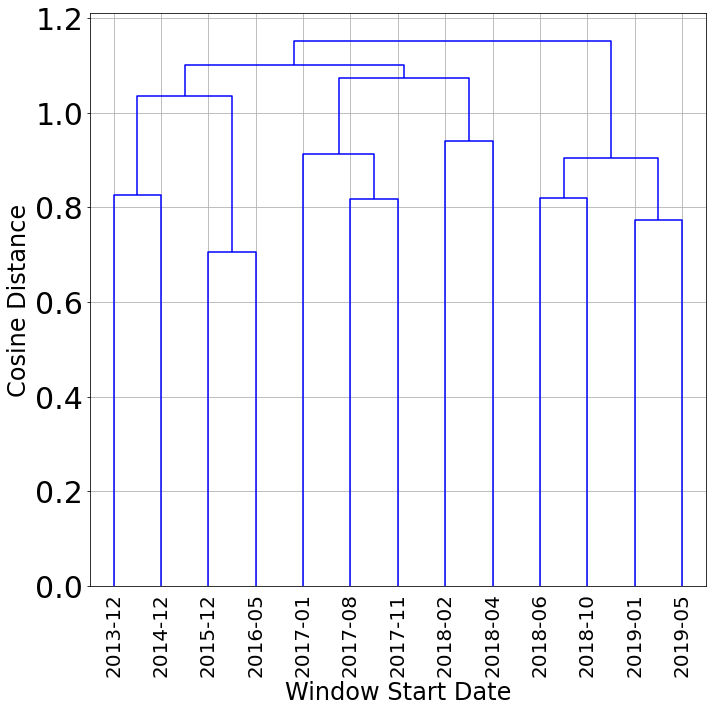

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
vnc.draw_dendrogram(ax=ax, colour="blue")
ax.set_xlabel("Window Start Date", fontsize=24)
ax.set_ylabel("Cosine Distance", fontsize=24)
plt.tight_layout()
ax.grid()
plt.show()

In [15]:
def renumber_cluster(clusts):
    c_list = []
    c_map = dict()
    n_clusts = []
    for c in clusts:
        if c not in c_list:
            c_list.append(c)
            c_map[c] = len(c_list)
        n_clusts.append(c_map[c])
    return np.array(n_clusts)

In [16]:
def plot_cluster_kw(clusters, window_posts, toks, clust_windows):
    num_clusts = len(set(clusters))
    fig, axes = plt.subplots(1, num_clusts, figsize=(10*num_clusts, 8))
    
    kw_dic = dict()
    for i, clust in enumerate(set(clusters)):
        curr_clust_windows = clust_windows[clusters == clust]
        clust_indices = merge_lists([window_posts[w] for w in curr_clust_windows])
        clust_toks = toks.loc[clust_indices]
        non_clust_toks = toks[~toks.index.isin(clust_indices)]
        kw = get_ngram_lr_and_ll(clust_toks, non_clust_toks, 1, "_")
        kw = kw.query("LR > 1 and freq1 > 100").sort_values("LR", ascending=False).head(100)["LR"]
        kw_dic[clust] = kw
        
        cloud = make_wordcloud(kw)
        axes[i].imshow(cloud, aspect="auto")
        
        axes[i].axes.xaxis.set_ticks([])
        axes[i].axes.yaxis.set_ticks([])
        axes[i].set_title(clust)
        
    plt.show()
    return plot_cluster_kw

In [17]:
clusters = renumber_cluster(vnc.get_clusters(1))
clusters = renumber_cluster(vnc.get_clusters(0.33))
clusters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

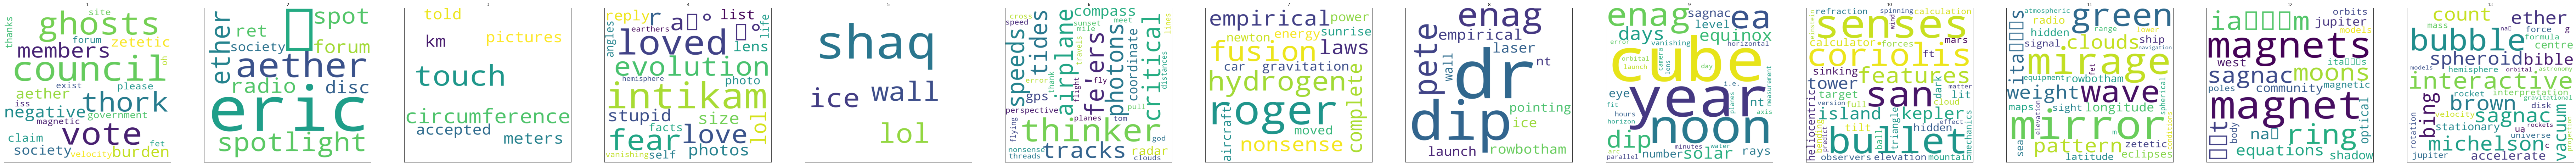

Wall time: 1min 53s


In [18]:
%%time
window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(fe_posts, 5000, 5000)}
vnc_windows = vnc.matrix.index

kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows)

In [19]:
# Plot the overall frequencies with the windows marked on
clust_starts = [vnc_windows[clusters==c][0] for c in set(clusters)]

In [20]:
clust_starts

[Timestamp('2013-12-01 18:43:04'),
 Timestamp('2014-12-24 05:06:28'),
 Timestamp('2015-12-30 23:54:31'),
 Timestamp('2016-05-08 06:58:04'),
 Timestamp('2017-01-16 01:34:55'),
 Timestamp('2017-08-11 16:09:44'),
 Timestamp('2017-11-09 16:57:19'),
 Timestamp('2018-02-01 18:32:10'),
 Timestamp('2018-04-20 09:03:11'),
 Timestamp('2018-06-27 13:53:13'),
 Timestamp('2018-10-07 05:55:37'),
 Timestamp('2019-01-12 02:07:46'),
 Timestamp('2019-05-23 23:19:09')]

In [21]:
window_toks

2013-12-01 18:43:04    [the, faq, is, continually, updated, and, adju...
2014-12-24 05:06:28    [since, you, 've, made, your, outlandish, clai...
2015-12-30 23:54:31    [i, read, the, faq, before, i, posted, ., but,...
2016-05-08 06:58:04    [haha, ,, excellent, retort, ., i, was, actual...
2017-01-16 01:34:55    [now, ,, i, readily, admit, that, i, 'm, no, m...
2017-08-11 16:09:44    [oh, dear, ., i, did, n't, want, to, complicat...
2017-11-09 16:57:19    [that, 's, not, true, -, there, have, been, a,...
2018-02-01 18:32:10    [just, checking, ,, but, did, anyone, here, go...
2018-04-20 09:03:11    [yet, ..., most, every, photo, i, see, from, a...
2018-06-27 13:53:13    [can, you, explain, your, objection, in, a, li...
2018-10-07 05:55:37    [thatâs, a, meaningless, statement, ., itâ...
2019-01-12 02:07:46    [my, original, post, mentioned, nothing, about...
2019-05-23 23:19:09    [once, again, ,, i, point, you, to, the, video...
dtype: object

In [22]:
# %%time
# time_window_post_counts = [[window, len(posts)] for window, posts in get_time_windows(fe_posts, 90, 30, time_column="time")]
# time_window_post_counts = pd.Series([x[1] for x in time_window_post_counts], index=[x[0] for x in time_window_post_counts])

In [23]:
# %%time
# def plot_epochs_against_posts_old(time_window_post_counts, clust_starts, out_fp):
#     fig, ax = plt.subplots(figsize=(10,6))

#     ax.plot(time_window_post_counts.index, time_window_post_counts.values, c="#7fbf7b")
#     for c_start in clust_starts:
#         ax.axvline(c_start, c="#af8dc3", linestyle="--")

#     ax.set_ylabel("Num Posts", size=14)
#     ax.set_xlabel("Time", size=14)

#     for tick in ax.xaxis.get_ticklabels():
#         tick.set_size(14)

#     for tick in ax.yaxis.get_ticklabels():
#         tick.set_size(14)

#     ax.grid()
#     if out_fp is not None:
#         fig.savefig(out_fp)
#     plt.show()

In [24]:
%%time
def plot_epochs_against_posts(times, counts, clust_starts, out_fp):
    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(times, counts, c="#7fbf7b", lw=3)
    for c_start in clust_starts:
        ax.axvline(c_start, c="#af8dc3", linestyle="--", lw=2)
        ax.annotate()

    ax.set_ylabel("Num Posts", size=14)
    ax.set_xlabel("Time", size=14)

    for tick in ax.xaxis.get_ticklabels():
        tick.set_size(14)

    for tick in ax.yaxis.get_ticklabels():
        tick.set_size(14)

    ax.grid()
    if out_fp is not None:
        fig.savefig(out_fp)
    plt.show()

Wall time: 0 ns


In [25]:
%%time
import matplotlib.gridspec as gridspec
def plot_epochs_against_posts(times, counts, clust_starts, out_fp):
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 12], hspace=0)
    ax = plt.subplot(gs[1])
    ax_labels = plt.subplot(gs[0], sharex=ax)
    
    # Sort out the label axis
    ax_labels.set_ylim(-0.3,0.3)
    ax_labels.axis("off")

    ax.plot(times, counts, c="#7fbf7b", lw=3)
    for i, c_start in enumerate(clust_starts):
        ax.axvline(c_start, c="#af8dc3", linestyle="--", lw=2)
        ax_labels.annotate(text=str(i+1), xy=(c_start,0), xytext=(c_start,0), 
                           horizontalalignment="center", verticalalignment="center", fontsize=16)

    ax.set_ylabel("Num Posts", size=14)
    ax.set_xlabel("Time", size=14)

    for tick in ax.xaxis.get_ticklabels():
        tick.set_size(14)

    for tick in ax.yaxis.get_ticklabels():
        tick.set_size(14)

    ax.grid()
    if out_fp is not None:
        fig.savefig(out_fp)
    plt.show()

Wall time: 0 ns


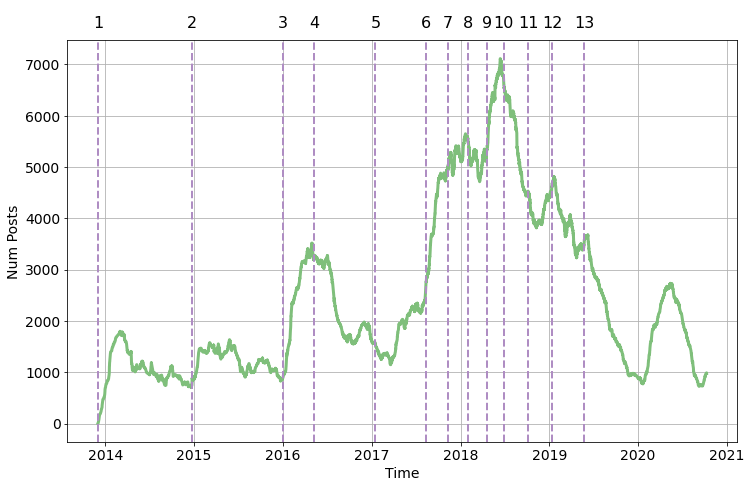

Wall time: 260 ms


In [26]:
%%time
rolling_counts = fe_posts.rolling("90D", on="time").count()
plot_epochs_against_posts(rolling_counts["time"], rolling_counts["topic_id"], clust_starts, None)

## Now with binary features

Cophenetic Correlation Coefficient: 0.661361743584868


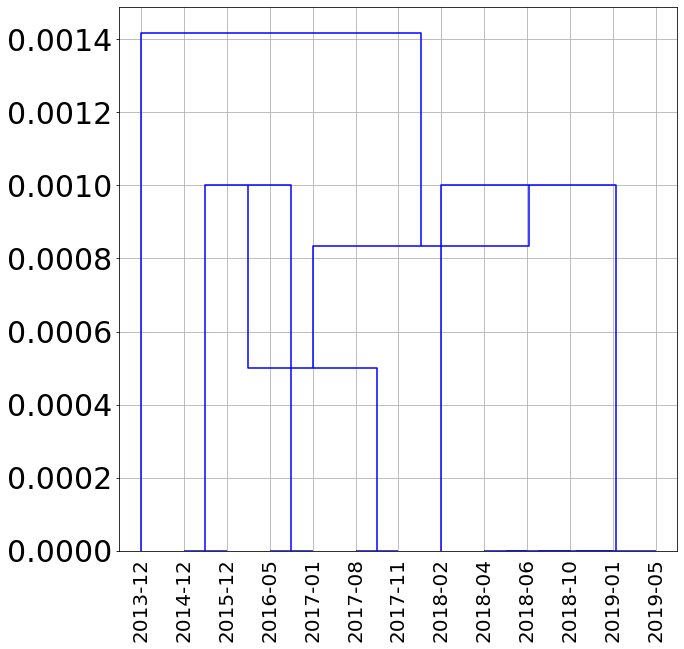

Wall time: 1.39 s


In [27]:
%%time

feats = pd.DataFrame(bin_feats, index=bow_counts.index, columns=curr_feat_names)

vnc = VNC(feats, jaccard_score)
c, coph_dists = cophenet(vnc.d_list, pdist(feats, metric="jaccard"))
print("Cophenetic Correlation Coefficient: {}".format(c))

fig, ax = plt.subplots(figsize=(10,10))
vnc.draw_dendrogram(ax=ax, colour="blue")
ax.grid()
plt.show()

## With different feature sets

-----------------------------------------------------------------
BoW
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.7843426445109498


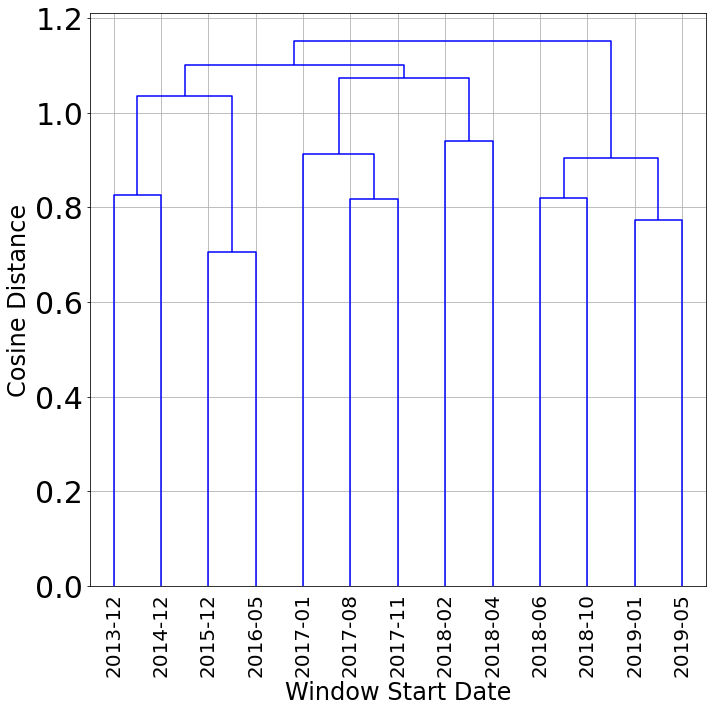

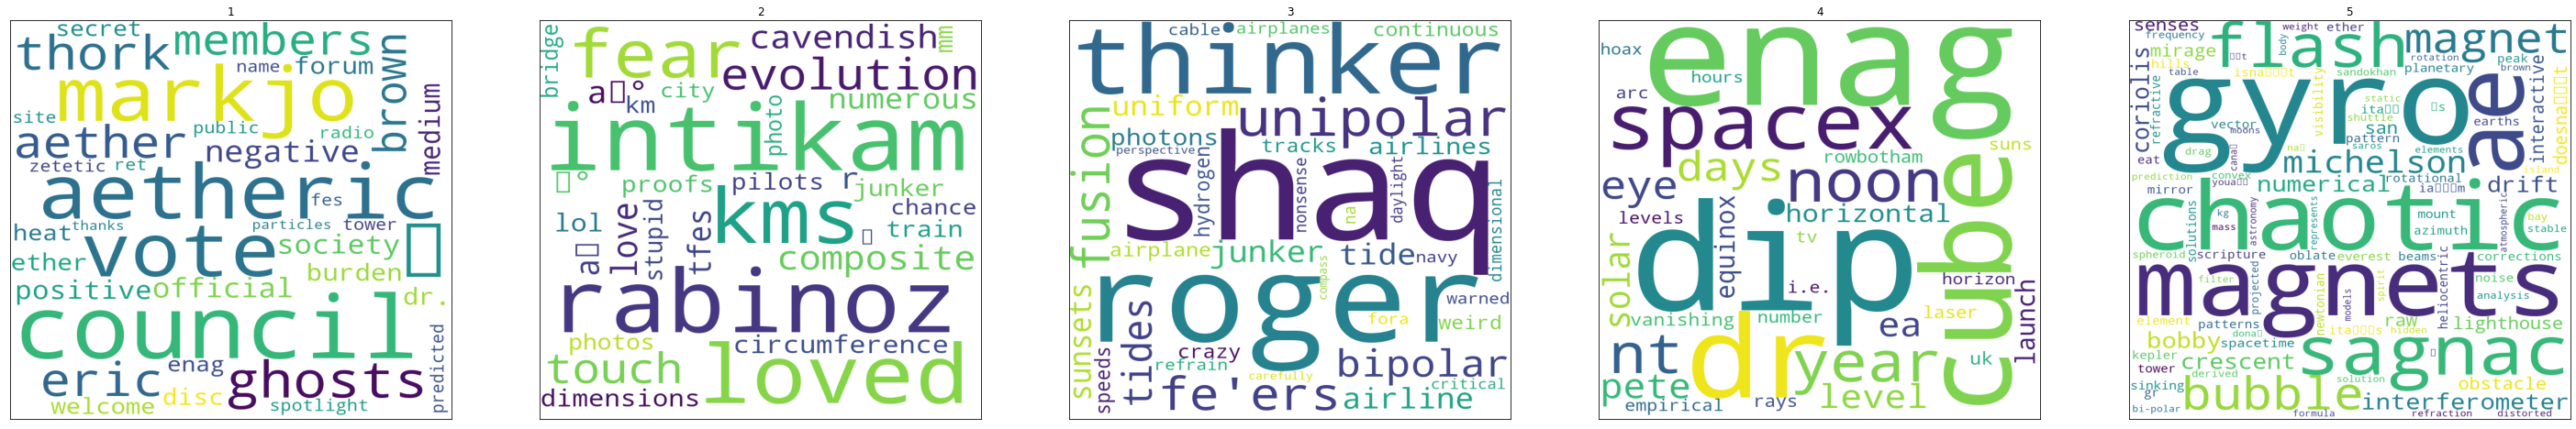

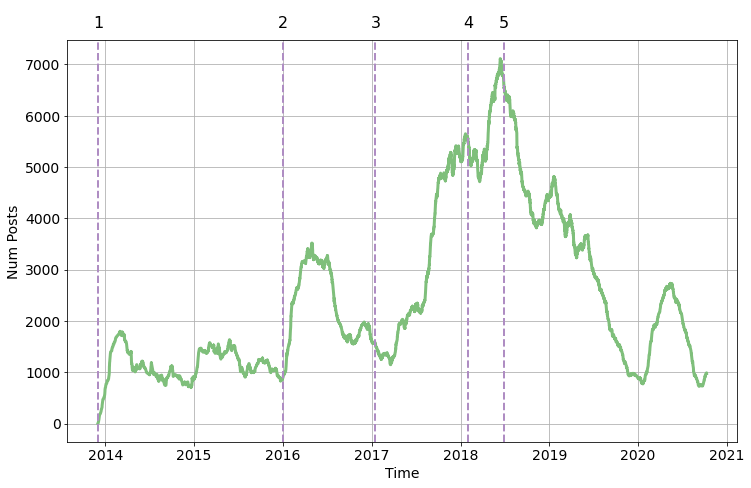

-----------------------------------------------------------------
PoS Trigrams
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.8547540622723628


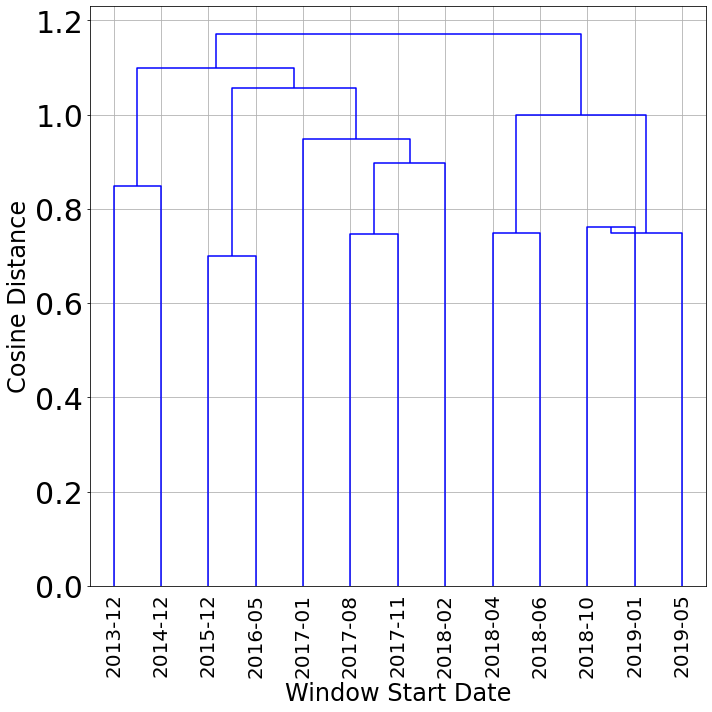

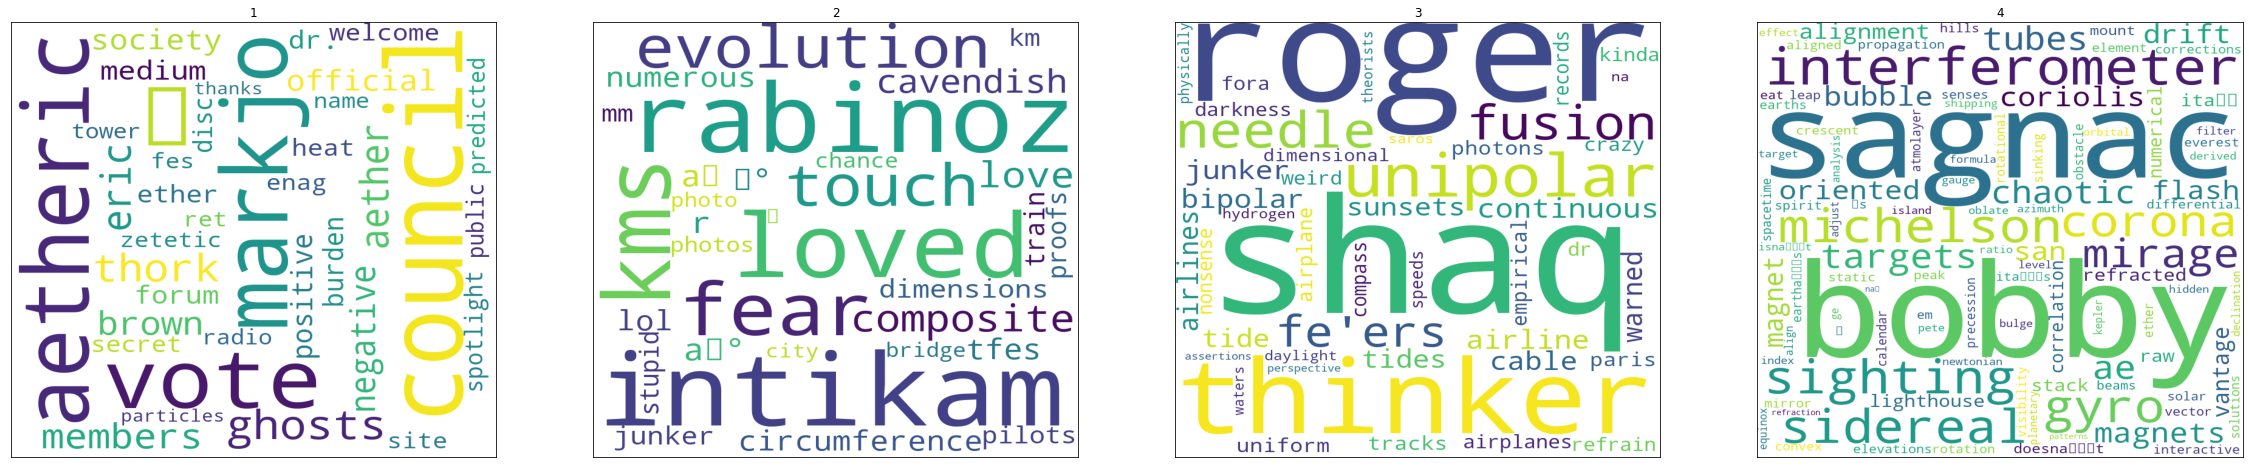

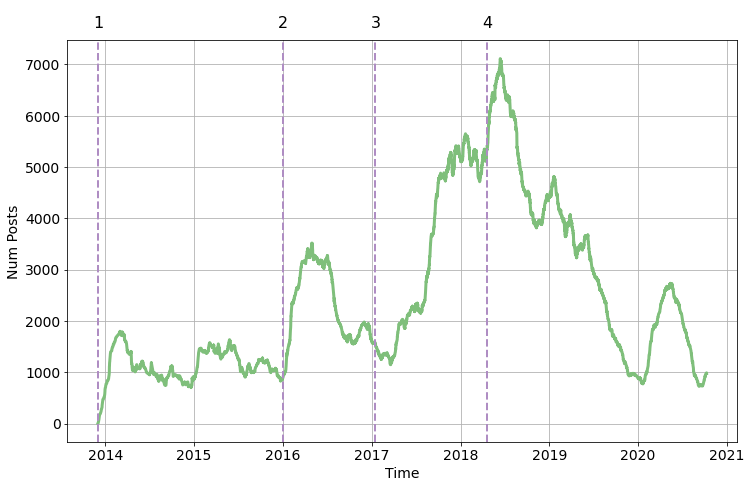

-----------------------------------------------------------------
Char Trigrams
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.8175337624254501


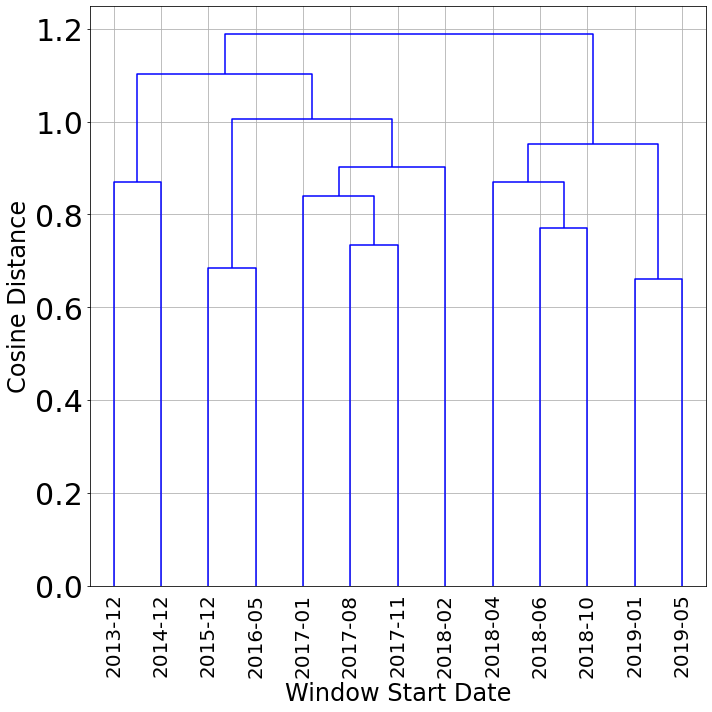

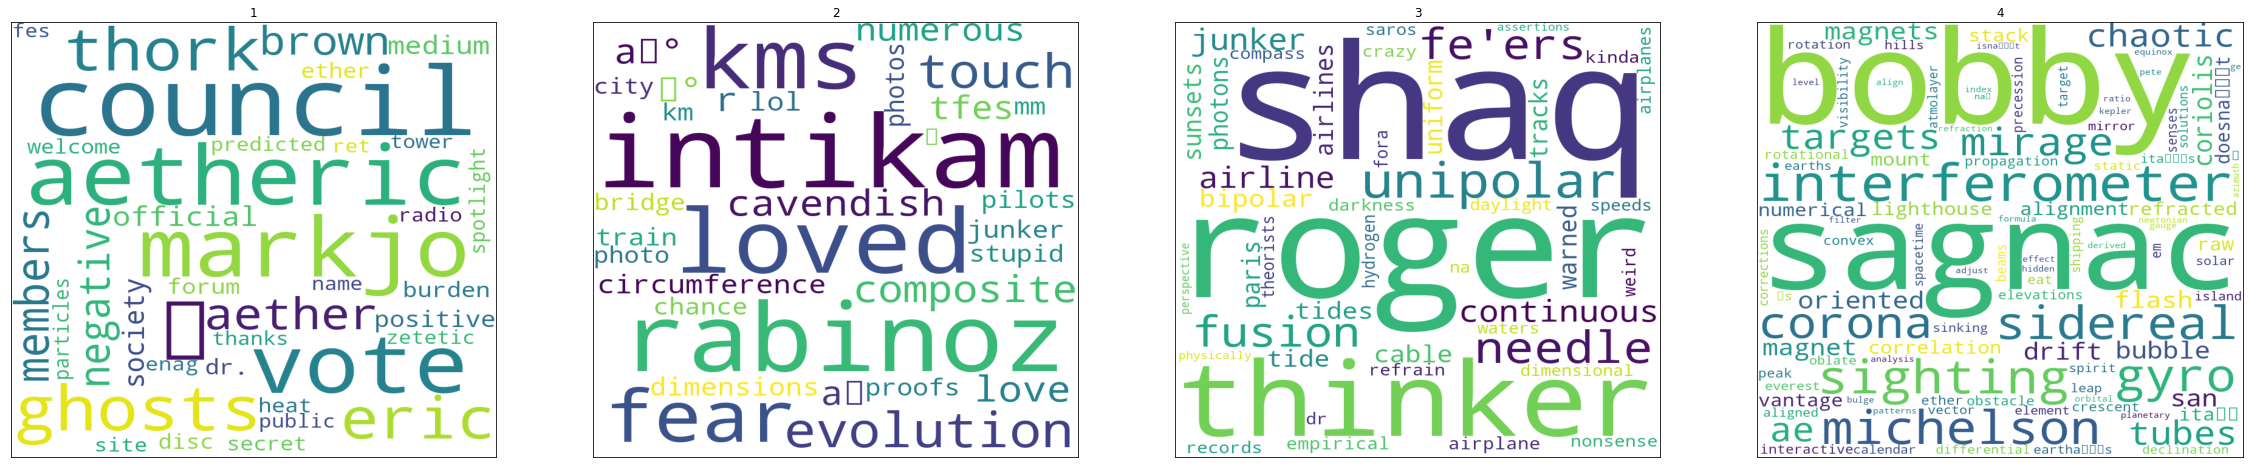

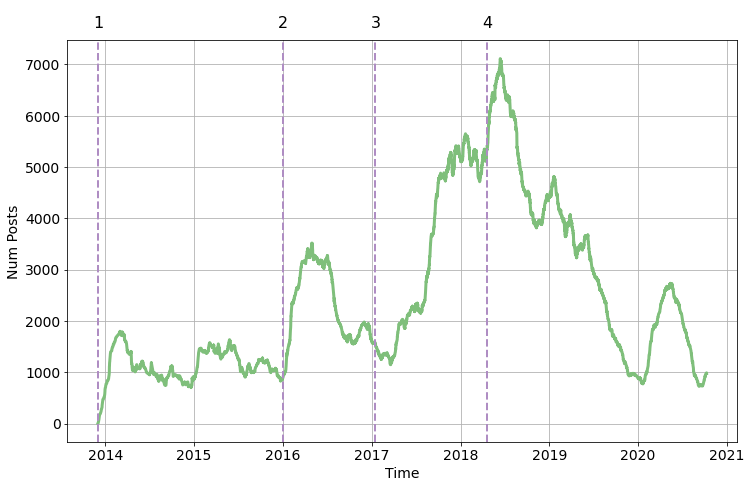

Wall time: 1min 57s


In [28]:
%%time
for curr_name, curr_counts in zip(["BoW", "PoS Trigrams", "Char Trigrams"], [bow_counts, pos_tri_counts, char_tri_counts]):
    # Make the feature matrix
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / window_toks.apply(len).values[:,None]
    
    feats = StandardScaler().fit_transform(norm_feats)
    feats = pd.DataFrame(feats, index=curr_counts.index, columns=curr_feat_names)

    print("-----------------------------------------------------------------")
    print(curr_name)
    print("-----------------------------------------------------------------")
    
    vnc = VNC(feats, cosine_sim)
    c, coph_dists = cophenet(vnc.d_list, pdist(feats, metric="cosine"))
    print("Cophenetic Correlation Coefficient: {}".format(c))

    fig, ax = plt.subplots(figsize=(10,10))
    vnc.draw_dendrogram(ax=ax, colour="blue")
    ax.set_xlabel("Window Start Date", fontsize=24)
    ax.set_ylabel("Cosine Distance", fontsize=24)
    plt.tight_layout()
    ax.grid()
    plt.show()
    
    clusters = renumber_cluster(vnc.get_clusters(1))
    window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(fe_posts, 5000, 5000)}
    vnc_windows = vnc.matrix.index
    
    fig.savefig(os.path.join(OUT_DIR, f"tfes_{curr_name}_vnc.pdf"))

    kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows)
    
    clust_starts = [vnc_windows[clusters==c][0] for c in set(clusters)]
    rolling_counts = fe_posts.rolling("90D", on="time").count()
    plot_epochs_against_posts(rolling_counts["time"], rolling_counts["topic_id"], clust_starts, 
                              os.path.join(OUT_DIR, f"tfes_{curr_name}_vnc_meta_comparison.pdf"))

-----------------------------------------------------------------
BoW
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.8412605059595173


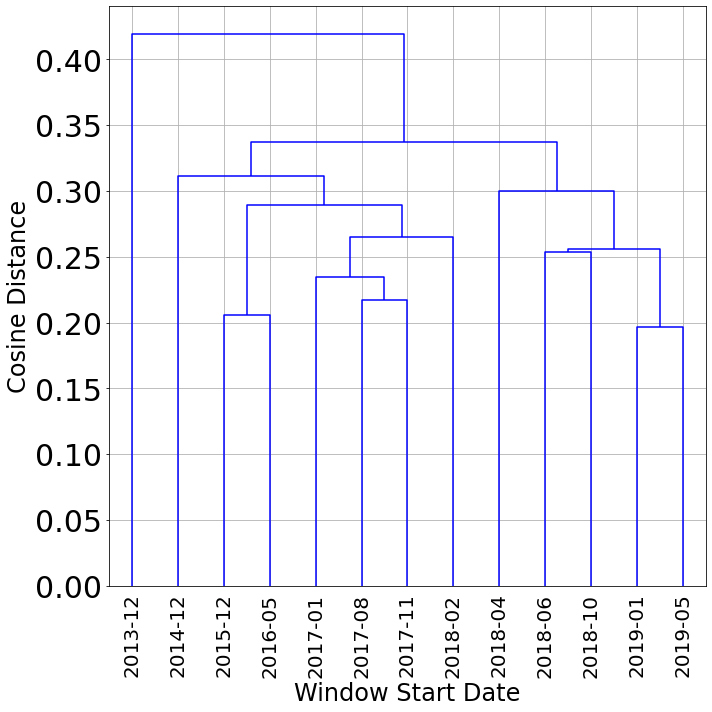

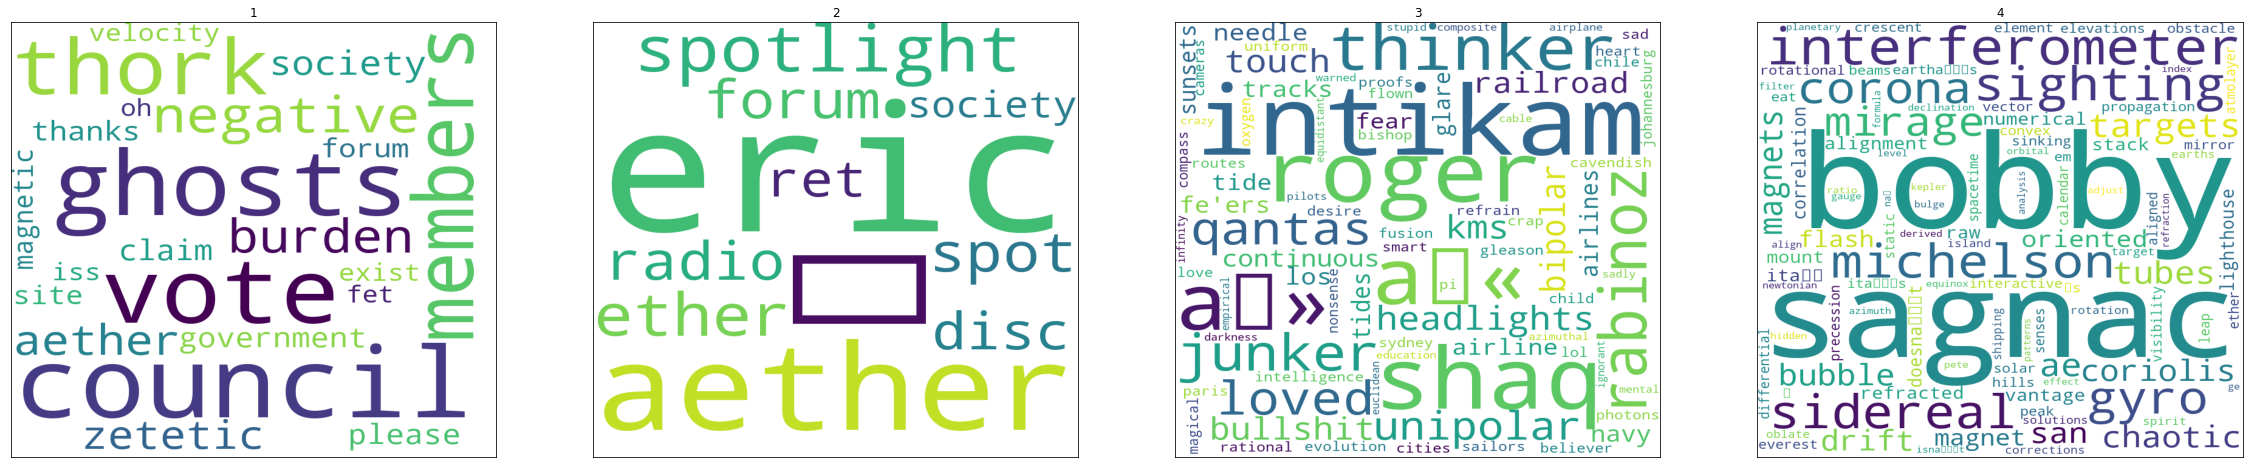

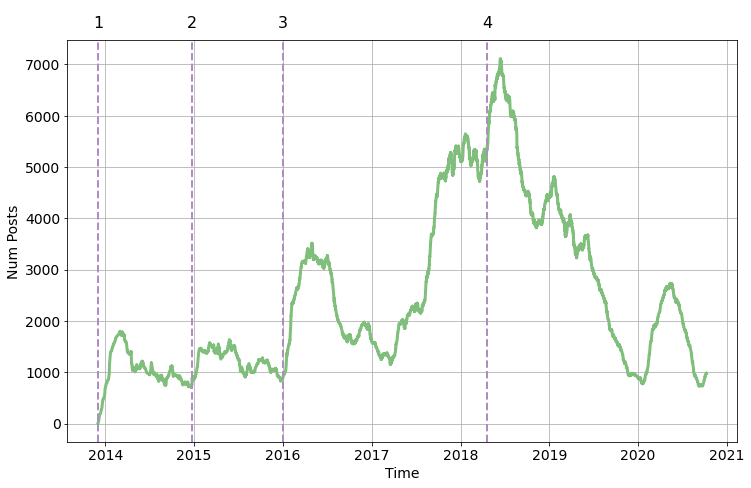

-----------------------------------------------------------------
PoS Trigrams
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.786150237056208


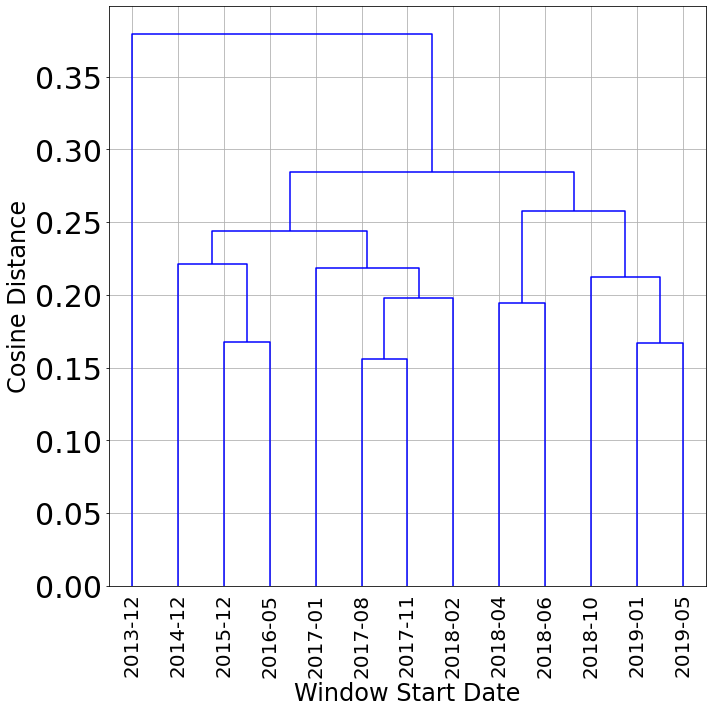

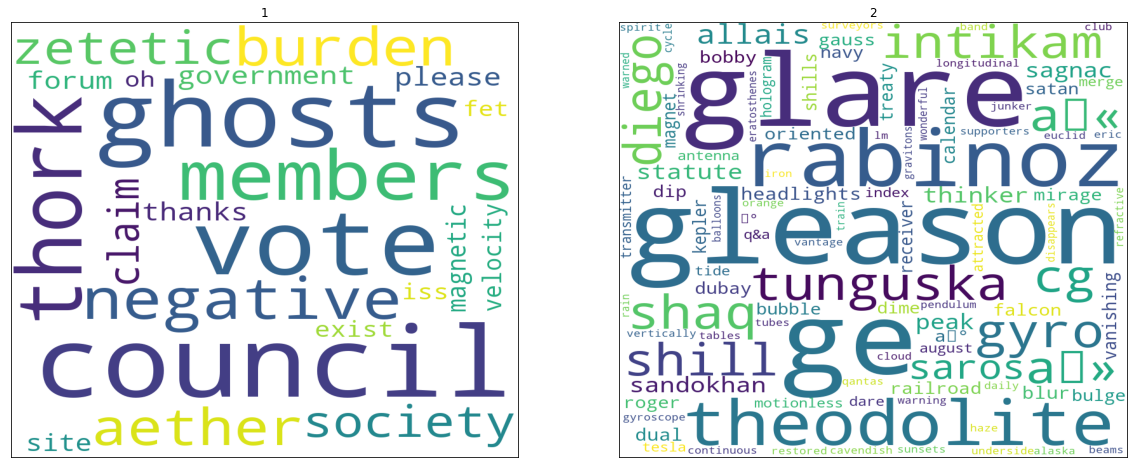

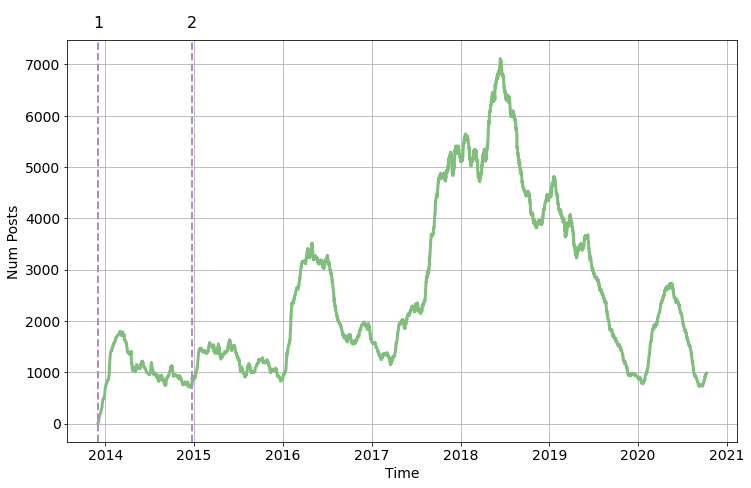

-----------------------------------------------------------------
Char Trigrams
-----------------------------------------------------------------
Cophenetic Correlation Coefficient: 0.6916367505559003


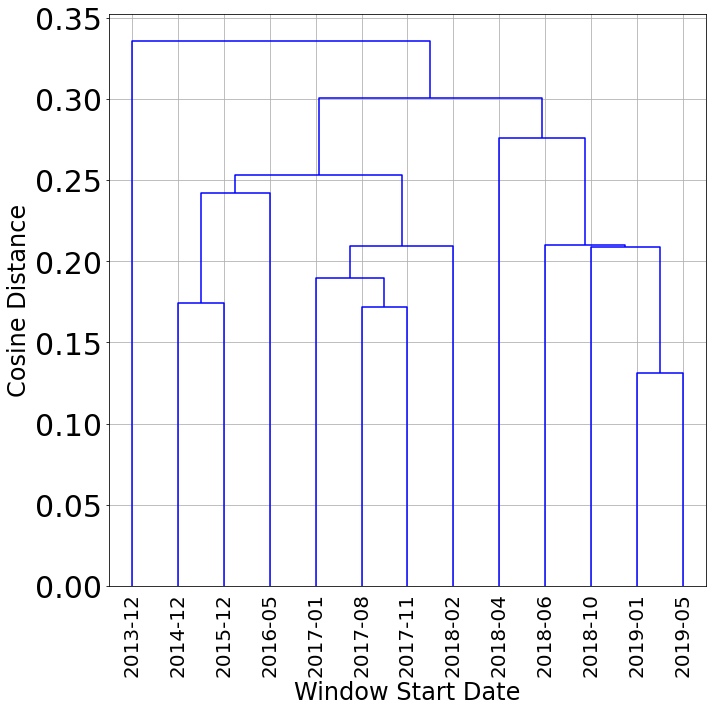

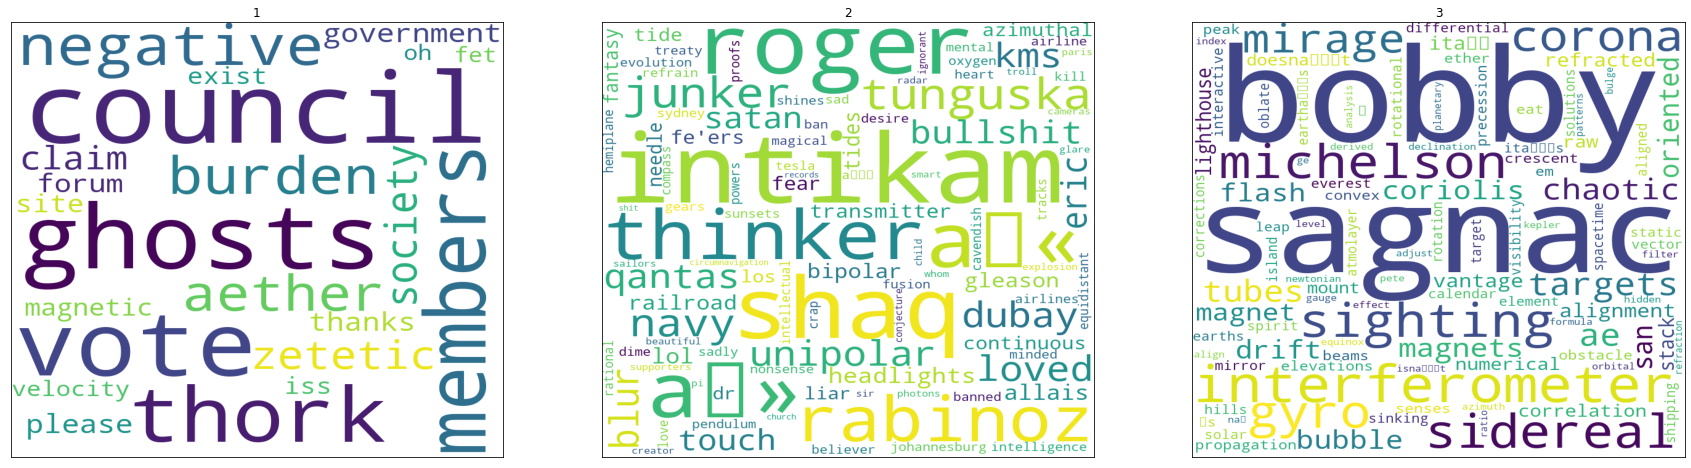

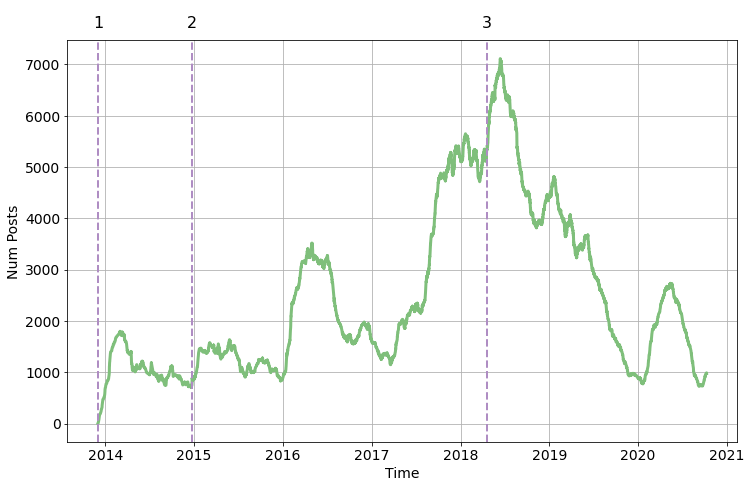

Wall time: 1min 22s


In [29]:
%%time
for curr_name, curr_counts in zip(["BoW", "PoS Trigrams", "Char Trigrams"], [bow_counts, pos_tri_counts, char_tri_counts]):
    # Make the feature matrix
    curr_feats, curr_feat_names = make_feature_matrix(curr_counts.to_dict(), False)
    bin_feats = np.vectorize(lambda x: 1 if x > 0 else 0)(curr_feats)
    norm_feats = curr_feats / window_toks.apply(len).values[:,None]
    
    feats = MinMaxScaler().fit_transform(norm_feats)
    feats = pd.DataFrame(feats, index=bow_counts.index, columns=curr_feat_names)

    print("-----------------------------------------------------------------")
    print(curr_name)
    print("-----------------------------------------------------------------")
    
    vnc = VNC(feats, cosine_sim)
    c, coph_dists = cophenet(vnc.d_list, pdist(feats, metric="cosine"))
    print("Cophenetic Correlation Coefficient: {}".format(c))

    fig, ax = plt.subplots(figsize=(10,10))
    vnc.draw_dendrogram(ax=ax, colour="blue")
    ax.set_xlabel("Window Start Date", fontsize=24)
    ax.set_ylabel("Cosine Distance", fontsize=24)
    plt.tight_layout()
    ax.grid()
    plt.show()
    
    clusters = renumber_cluster(vnc.get_clusters(0.3))
    window_posts = {w: curr_posts.index for w, curr_posts in get_data_windows(fe_posts, 5000, 5000)}
    vnc_windows = vnc.matrix.index
    
    fig.savefig(os.path.join(OUT_DIR, f"minmax_tfes_{curr_name}_vnc.pdf"))

    kw = plot_cluster_kw(clusters, window_posts, toks, vnc_windows)
    
    clust_starts = [vnc_windows[clusters==c][0] for c in set(clusters)]
    rolling_counts = fe_posts.rolling("90D", on="time").count()
    plot_epochs_against_posts(rolling_counts["time"], rolling_counts["topic_id"], clust_starts, None)

In [30]:
import re
fe_posts[toks.apply(lambda x: "council" in x)].body.iloc[2]

'Not only do I think this council thing is a stupid idea, I protest the fact there is no section for write-in candidates. I also disagree with how this election is being run, as well as the lack of oversight. I also suspect Thork of stuffing the ballots.'

In [31]:
bow_counts

2013-12-01 18:43:04    {'faq': 77, 'members': 196, 'flat': 873, 'eart...
2014-12-24 05:06:28    {''ve': 385, 'made': 368, 'claim': 278, 'again...
2015-12-30 23:54:31    {'read': 326, 'faq': 89, 'posted': 121, '.': 2...
2016-05-08 06:58:04    {',': 18162, '.': 24124, 'actually': 457, 'thi...
2017-01-16 01:34:55    {'now': 465, ',': 16454, 'admit': 54, ''m': 71...
2017-08-11 16:09:44    {'oh': 134, '.': 22809, 'did': 654, 'n't': 401...
2017-11-09 16:57:19    {''s': 3262, 'not': 4210, 'true': 330, '-': 30...
2018-02-01 18:32:10    {'just': 1402, ',': 17388, 'did': 740, 'here':...
2018-04-20 09:03:11    {'...': 869, 'photo': 112, 'see': 1295, 'has':...
2018-06-27 13:53:13    {'explain': 410, 'detail': 59, '?': 4203, 'are...
2018-10-07 05:55:37    {'statement': 101, '.': 26378, 's': 99, 'just...
2019-01-12 02:07:46    {'original': 130, 'post': 263, 'mentioned': 62...
2019-05-23 23:19:09    {'again': 393, ',': 20437, 'point': 905, 'vide...
dtype: object

In [32]:
window_toks

2013-12-01 18:43:04    [the, faq, is, continually, updated, and, adju...
2014-12-24 05:06:28    [since, you, 've, made, your, outlandish, clai...
2015-12-30 23:54:31    [i, read, the, faq, before, i, posted, ., but,...
2016-05-08 06:58:04    [haha, ,, excellent, retort, ., i, was, actual...
2017-01-16 01:34:55    [now, ,, i, readily, admit, that, i, 'm, no, m...
2017-08-11 16:09:44    [oh, dear, ., i, did, n't, want, to, complicat...
2017-11-09 16:57:19    [that, 's, not, true, -, there, have, been, a,...
2018-02-01 18:32:10    [just, checking, ,, but, did, anyone, here, go...
2018-04-20 09:03:11    [yet, ..., most, every, photo, i, see, from, a...
2018-06-27 13:53:13    [can, you, explain, your, objection, in, a, li...
2018-10-07 05:55:37    [thatâs, a, meaningless, statement, ., itâ...
2019-01-12 02:07:46    [my, original, post, mentioned, nothing, about...
2019-05-23 23:19:09    [once, again, ,, i, point, you, to, the, video...
dtype: object

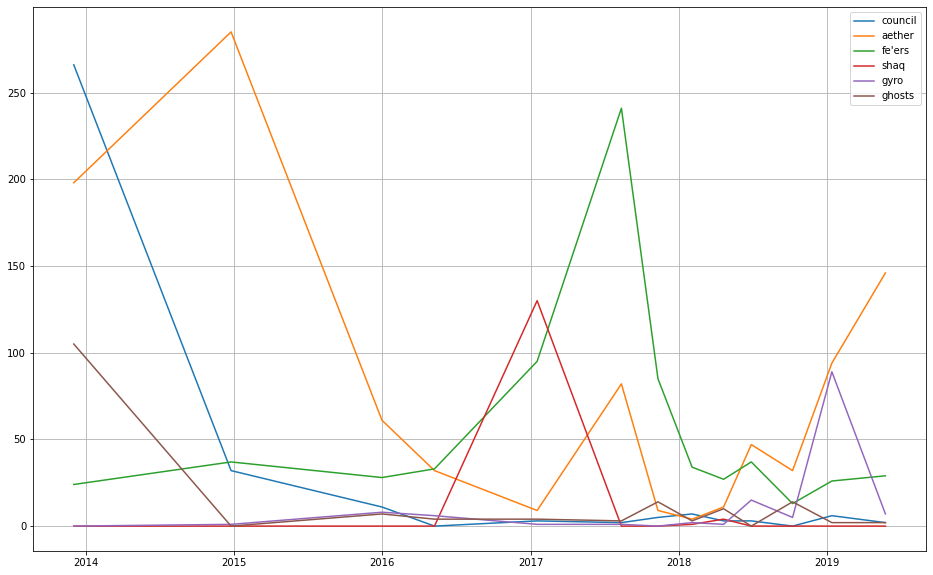

In [33]:
from collections import Counter

words_of_interest = ["council", "aether", "fe'ers", "shaq", "gyro", "ghosts"]

all_word_counts = window_toks.apply(Counter)

words_to_plot = {w: [c[w] for c in all_word_counts.values] for w in words_of_interest}

fig, ax = plt.subplots(figsize=(16,10))

for w, c in words_to_plot.items():
    ax.plot(all_word_counts.index, c, label=w)
    
ax.legend()
ax.grid()
plt.show()

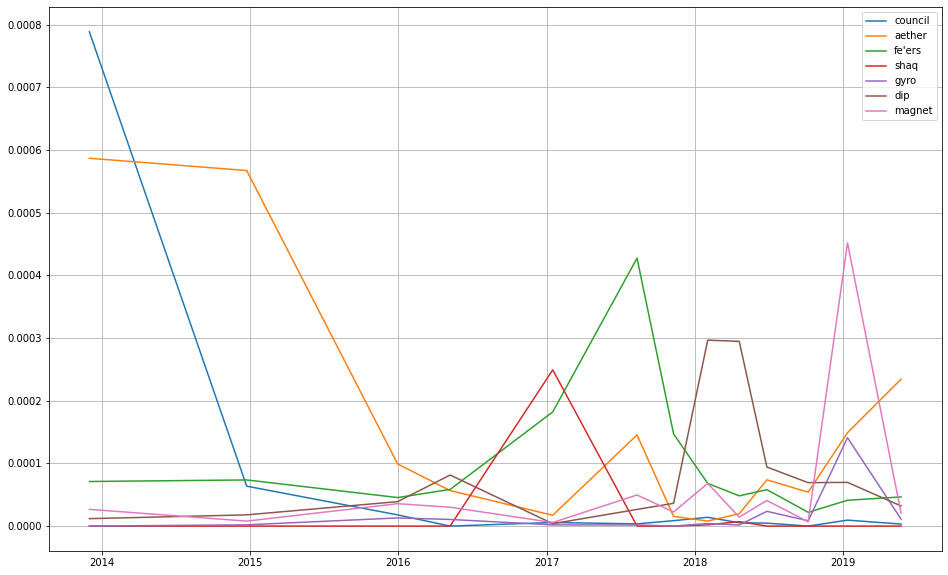

In [34]:
from collections import Counter

words_of_interest = ["council", "aether", "fe'ers", "shaq", "gyro", "dip", "magnet"]

all_word_counts = window_toks.apply(Counter)

words_to_plot = {w: [c[w] / sum(c.values()) for c in all_word_counts.values] for w in words_of_interest}

fig, ax = plt.subplots(figsize=(16,10))

for w, c in words_to_plot.items():
    ax.plot(all_word_counts.index, c, label=w)
    
ax.legend()
ax.grid()
plt.show()

In [35]:
fe_posts.rolling("90D", on="time").count().loc[:,["time", "topic_id"]]

time  topic_id
40     2013-12-01 18:43:04       1.0
192    2013-12-02 01:43:59       2.0
195    2013-12-02 01:47:24       3.0
198    2013-12-02 01:59:15       4.0
203    2013-12-02 02:37:29       5.0
...                    ...       ...
126194 2020-10-08 17:09:56     988.0
126195 2020-10-08 17:27:43     989.0
126196 2020-10-08 19:11:04     989.0
126199 2020-10-08 21:01:07     984.0
126200 2020-10-08 23:37:36     976.0

[69088 rows x 2 columns]